# hc eval and test

## common

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocessing as mp
from datetime import datetime
import traceback
import sys
sys.path.insert(0, '../../data/siim-pneumothorax')

import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image

fastai.__version__


'1.0.54'

In [2]:
sz = 512
bs = 2
n_acc = 64//bs #gradinet accumulation steps
nfolds = 4
SEED = 2019

data_path = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

if sz == 256:
    stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
    TRAIN = os.path.join(data_path, 'train_png_256')
    TEST = os.path.join(data_path, 'test_png_256')
    MASKS = os.path.join(data_path, 'mask_png_256')
elif sz == 128:
    stats = ([0.615,0.615,0.615],[0.291,0.291,0.291])
    TRAIN = '../input/siimacr-pneumothorax-segmentation-data-128/train'
    TEST = '../input/siimacr-pneumothorax-segmentation-data-128/test'
    MASKS = '../input/siimacr-pneumothorax-segmentation-data-128/masks'
elif sz > 256:
    stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
    TRAIN = os.path.join(data_path, 'train_png')
    TEST = os.path.join(data_path, 'test_png')
    MASKS = os.path.join(data_path, 'mask_png')
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)

In [3]:
from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

class Hcolumns(nn.Module):
    def __init__(self, hooks:Collection[Hook], nc:Collection[int]=None):
        super(Hcolumns,self).__init__()
        self.hooks = hooks
        self.n = len(self.hooks)
        self.factorization = None 
        if nc is not None:
            self.factorization = nn.ModuleList()
            for i in range(self.n):
                self.factorization.append(nn.Sequential(
                    conv2d(nc[i],nc[-1],3,padding=1,bias=True),
                    conv2d(nc[-1],nc[-1],3,padding=1,bias=True)))
                #self.factorization.append(conv2d(nc[i],nc[-1],3,padding=1,bias=True))
        
    def forward(self, x:Tensor):
        n = len(self.hooks)
        out = [F.interpolate(self.hooks[i].stored if self.factorization is None
            else self.factorization[i](self.hooks[i].stored), scale_factor=2**(self.n-i),
            mode='bilinear',align_corners=False) for i in range(self.n)] + [x]
        return torch.cat(out, dim=1)

class DynamicUnet_Hcolumns(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, 
                 self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        self.hc_hooks = [Hook(layers[-1], _hook_inner, detach=False)]
        hc_c = [x.shape[1]]
        
        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, 
                blur=blur, self_attention=sa, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)
            self.hc_hooks.append(Hook(layers[-1], _hook_inner, detach=False))
            hc_c.append(x.shape[1])

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        hc_c.append(ni)
        layers.append(Hcolumns(self.hc_hooks, hc_c))
        layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
        norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
        blur:bool=False, self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, 
        last_cross:bool=True, bottle:bool=False, cut:Union[int,Callable]=None, 
        hypercolumns=True, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    M = DynamicUnet_Hcolumns if hypercolumns else DynamicUnet
    model = to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
        self_attention=self_attention, y_range=y_range, norm_type=norm_type, 
        last_cross=last_cross, bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [4]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [5]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [6]:
def get_preds(learn, ds_type=DatasetType.Valid):
    preds = []
    ys = []
    
    model = learn.model
    model.eval()
    
    dl = learn.dl(ds_type)
    
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            pred = model(xb)
            pred = F.softmax(pred, dim=1)
            
            preds.append(to_detach(pred))
            ys.append(yb.cpu())
            
    del pred
    gc.collect()
    torch.cuda.empty_cache()
    
    return torch.cat(preds),torch.cat(ys)

In [7]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    # preds, ys = learn.get_preds(ds_type)
    preds, ys = get_preds(learn, ds_type)
    preds = preds[:,1,...]
    
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = get_preds(learn, ds_type)
    
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    
    del preds_lr
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, ys

In [8]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

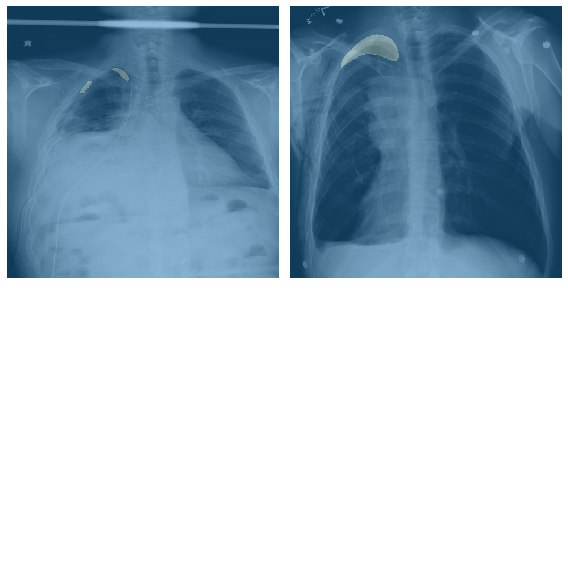

In [9]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'mask'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

#### common config

In [10]:
tag = '20190718-105908_512'
self_attention = False

## eval

In [15]:
for fold in range(nfolds):
    print('fold: ', fold)

    data = get_data(fold)

    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=self_attention)
    learn.load('hc_{}_fold{}'.format(tag, fold))

    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    
    # save preds and ys
    torch.save(preds.cpu(), 'hc_preds_{}_fold{}.pth'.format(tag, fold))
    torch.save(ys.cpu(), 'hc_ys_{}_fold{}.pth'.format(tag, fold))

    # clean up
    if fold != nfolds-1: 
        del learn, data

    gc.collect()
    torch.cuda.empty_cache()

fold:  0


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  1


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  2


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  3


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
# find best_thr

scores, best_thrs = [], []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0
    
    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
        
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])

fold:  0


fold:  1


fold:  2


fold:  3


In [17]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

scores:  [0.8405922, 0.83576477, 0.8346497, 0.8385574]
mean score:  0.8373911
thresholds:  [0.23, 0.23, 0.26, 0.23]
best threshold:  0.2375


### classifier

now, we try to find out best_cls_thr - which means we use unet as classifier  
if unet predicts non-zero mask, the sample is positive, otherwise it's negative


In [11]:
# metric for classifier threshold selection

def accu_overall(preds, targs):
    n = preds.shape[0]
    
    preds = preds.view(n, -1).sum(-1)
    targs = targs.view(n, -1).sum(-1)
    
    preds = (preds[:,...]>0).long()
    targs = (targs[:,...]>0).long()
    
    accu = torch.eq(preds, targs).long().sum(-1).float() / n
    
    return accu

In [14]:
# find best_cls_thr

cls_scores, best_cls_thrs = [], []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    #remove noise
    #preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0
    
    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    accus = []
    thrs = np.arange(0.01, 1, 0.01)
    
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        accus.append(accu_overall(preds_m, ys).mean())
        
    accus = np.array(accus)    
    cls_scores.append(accus.max())
    best_cls_thrs.append(thrs[accus.argmax()])

fold:  0


fold:  1


fold:  2


fold:  3


In [15]:
print('cls_scores: ', cls_scores)
print('mean cls_scores: ', np.array(cls_scores).mean())
print('best_cls_thrs: ', best_cls_thrs)
best_cls_thr = np.array(best_cls_thrs).mean()
print('best threshold: ', best_cls_thr)

cls_scores:  [0.9002987, 0.8999253, 0.89507097, 0.90365946]
mean cls_scores:  0.89973867
best_cls_thrs:  [0.59, 0.41000000000000003, 0.47000000000000003, 0.41000000000000003]
best threshold:  0.47


## test

In [18]:
for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data(fold)
    
    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.load('hc_{}_fold{}'.format(tag, fold))
    
    #prediction on val and test sets
    pt, _ = pred_with_flip(learn, DatasetType.Test)
    
    torch.save(pt.cpu(), 'hc_pt_{}_fold{}'.format(tag, fold))
    
    # clean up
    if fold != nfolds-1: 
        del learn, data
    
    gc.collect()
    torch.cuda.empty_cache()

fold:  0


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  1


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  2


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  3


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
# load pt and average

for fold in range(nfolds):
    pt = torch.load('hc_pt_{}_fold{}'.format(tag, fold))
    
    if fold == 0:
        ptt = pt
    else:
        ptt += pt
        
ptt /= nfolds
print(ptt.shape)

torch.Size([1377, 512, 512])


In [35]:
# read test ids from sample submission file
# do NOT read from file list, since there're some non-diagnostic files

test_ids = [o.stem for o in get_data(0).test_ds.items]

sample_df = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))
sample_ids = list(sample_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)['ImageId'])

ids = []
ptt_filter = []

for i, sid in enumerate(test_ids):
    if sid in sample_ids:
        ids.append(sid)
        ptt_filter.append(ptt[i])
        
ptt = torch.stack(ptt_filter)
print(ptt.shape)

torch.Size([1372, 512, 512])


In [36]:
# noise removal

pt_clean = ptt.clone()
pt_clean[pt_clean.view(pt_clean.shape[0],-1).sum(-1) < noise_th,...] = 0.0
print(pt_clean.shape)

torch.Size([1372, 512, 512])


In [37]:
# apply classifier - for now, this does NOT give positive effect

best_cls_thr = 0.47
print('best_cls_thr: {}'.format(best_cls_thr))

ptt_cls = (pt_clean[:,...]>best_cls_thr).long()
ptt_cls = ptt_cls.sum((-2, -1))
ptt_cls = (ptt_cls[:,...]>0).long()

print(ptt_cls.sum())

for i, cls in enumerate(ptt_cls):
    if cls == 0:
        ptt[i, ...] = 0.0


best_cls_thr: 0.47
tensor(159)


In [38]:
# use leakage!
# this only works for stage-1!

leak_sample_df = pd.read_csv(os.path.join(data_path, "sample_submission_leak.csv"))

# this part was taken from @raddar's kernel: https://www.kaggle.com/raddar/better-sample-submission
masks_ = leak_sample_df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
masks_ = masks_.loc[masks_.N > 1].ImageId.values

# restore preds with multiple masks
for i, uid in enumerate(ids):
    if uid in masks_:
        pt_clean[i] = ptt[i]
            
print(pt_clean.shape)

torch.Size([1372, 512, 512])


In [39]:
# hard mask

best_thr = 0.2375
print('beat_thr: {}'.format(best_thr))

pt_mask = (pt_clean[:,...]>best_thr).long()
print(pt_mask.shape)

beat_thr: 0.2375
torch.Size([1372, 512, 512])


In [40]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)

    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, pt_mask.numpy())

In [41]:
# ok, export submission csv

sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
print(rle_list)
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('hc_sub_{}.csv'.format(tag), index=False)

sub_df.head()

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '567442 14 1010 14 1006 24 1000 24 996 34 990 34 988 40 984 40 982 42 982 42 982 42 982 42 980 44 980 44 978 46 978 46 978 46 978 46 976 48 976 48 976 46 978 46 978 46 978 46 976 46 978 46 978 46 978 46 978 46 978 46 976 46 978 46 978 46 978 46 978 44 980 44 980 44 980 44 980 42 982 42 980 44 980 44 980 44 980 44 980 44 980 44 980 42 982 42 982 42 982 42 982 42 982 42 982 42 982 42 982 40 984 40 984 40 984 40 984 40 984 40 984 40 984 40 986 38 986 38 986 38 986 38 986 38 986 38 986 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 36 988 36 988 36 988 36 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 990 34 992 32 992 32 992 32 992 32 992 32 460 4 528 32 460 4 528 32 458 8 526 32 458 8 528 30 456 10 528 30 456 10 528 30 456 10 528 30 456 10 530 28 456 10 530 28 456 10 530 28 454 14 528 28 454 14 528 30 452 14 528 30 452 1

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1
